In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.constants import *
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import yaml
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from scipy import interpolate

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [3]:
tilt = config['tilt'] * degrees 
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
clock = config['clock']
shape = config['shape']
pad_rot_angle = (config['pad_rot_angle']*math.pi)/180
electronics_gain = float(config['electronics_gain'])
micromegas_gain = float(config['micromegas_gain'])
diff_sigma = config['diffusion_sigma']
ioniz = 23.0 #eV

In [4]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785, 37, 24, 75, 72, 35, 16, 12, 1718, 1, 9
full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
evt_ID = 305
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]
xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

DRIFT_VEL = 5.2
CLOCK = 12.5

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 40.0:
        del_list.append(i)
    elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
        del_list.append(i)
    elif (xyzs[i][5] < 2.0): 
        del_list.append(i)         

cut_xyzs = np.delete(xyzs,del_list,axis=0)

print(xyzs[0])

[-1.45741499e+02  9.06868891e-01  1.86516085e+02  5.14131784e+02
  9.18200000e+03  4.00000000e+00  1.47813910e+01]


In [5]:
######finding center of curvature#######
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

-43.91625428724363 9.816445862844423


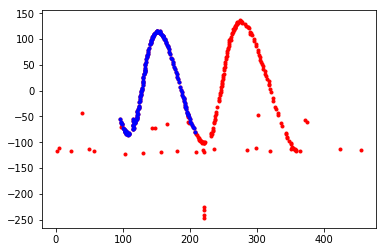

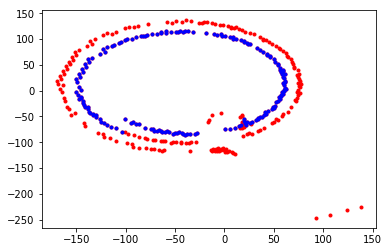

In [18]:
#######plotting real event#########
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

In [45]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
ctr0[4]=ctr0[4]+2*pi
print(ctr0)
cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False)
cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

[0.         0.         0.72005661 2.09442582 3.49679364 1.89956526]


In [46]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [72]:
####### generate a set of parameter vectors within given range #########
sig = config['sigma']
sigma = np.array([sig['x'],sig['y'],sig['z'],sig['enu'],sig['azi']*math.pi/180,sig['pol']*math.pi/180])

print(sigma)
num_events = 500
candidates = [sigma]
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle,\
                               beam_origin_z, gas, num_events,z0=ctr0[2],proj_pol=ctr0[5])

#, z0=ctr0[2],proj_pol=ctr0[5],proj_azi=ctr0[4]
for evt in pgen:
    p = evt[0]
    try:
        if abs(p[0]-ctr0[0]) >= sigma[0]:
            raise ValueError
        elif abs(p[1]-ctr0[1]) >= sigma[1]:
            raise ValueError
        elif abs(p[2]-ctr0[2]) >= sigma[2]:
            raise ValueError
        elif abs(p[3]-ctr0[3]) >= sigma[3]:
            raise ValueError
        elif abs(p[4]-ctr0[4]) >= sigma[4]:
            raise ValueError
        elif abs(p[5]-ctr0[5]) >= sigma[5]:
            raise ValueError
    except ValueError:
        continue
    candidates = np.append(candidates, [p], axis=0)

print(candidates)

[0.1        0.1        0.1        4.         1.04719755 0.52359878]
[[ 1.00000000e-01  1.00000000e-01  1.00000000e-01  4.00000000e+00
   1.04719755e+00  5.23598776e-01]
 [ 2.86189853e-04  6.77184868e-03  7.20056608e-01  1.22987483e+00
   2.91821020e+00  1.89670052e+00]
 [-3.66355449e-03 -4.17286447e-03  7.20056608e-01  1.22989363e+00
   2.92751086e+00  1.89317444e+00]
 ...
 [-1.28866289e-02 -5.71096243e-03  7.20056608e-01  1.22968476e+00
   2.93006696e+00  1.87249090e+00]
 [-7.46861573e-04 -1.24964760e-02  7.20056608e-01  1.22973697e+00
   2.93372659e+00  1.90411441e+00]
 [ 7.24172393e-03 -3.13320324e-03  7.20056608e-01  1.22985452e+00
   2.92485666e+00  1.91801087e+00]]


In [156]:
####### find position deviations ########
sigmaPos = 5.0 ### in m unit
Poschi2 = np.empty((0,0))
Poschi2_per_evt = np.empty((0,0))

sim = EventSimulator(config)
for num in range(1,len(candidates)):
    
    chi2Pos_x = np.empty((0,0))
    chi2Pos_y = np.empty((0,0))
    
    evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                   candidates[num][3], candidates[num][4], candidates[num][5])
    pyevtClean = sim.convert_event(evtClean)
    sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                               baseline_correction=True, cg_times=True)

    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)
    
    ##### find position chi2 #####
    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])

#    print(sim_x)
    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x))
#    sim_x[inds_x] = 100.0+xyzs[inds_x,0]
    
    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y))
#    sim_y[inds_y] = 100.0+xyzs[inds_y,1]
#    print(sim_x)
 
        
#    if np.isnan(sum(sim_x[inds_x]-xyzs[:,0])) == True:
#        Poschi2 = np.append(Poschi2,100.0)
#    elif np.isnan(sum(sim_y-xyzs[:,1])) == True:
#        Poschi2 = np.append(Poschi2,100.0)
#    else:
#    chi2Pos_x = np.append(chi2Pos_x,(sim_x-xyzs[:,0])/float(sigmaPos))    
#    chi2Pos_y = np.append(chi2Pos_y,(sim_y-xyzs[:,1])/float(sigmaPos)) 
#    Poschi2 = np.append(Poschi2,sum((chi2Pos_y**2+chi2Pos_x**2)/float(len(xyzs))))
        
#    print(Poschi2)
    
    for i in range(len(xyzs)):
        if np.in1d(i, inds_x[0]) == False:
            if np.in1d(i, inds_y[0]) == False:
#                print(i)
                chi2Pos_x = np.append(chi2Pos_x,(sim_x[i]-xyzs[i,0])/float(sigmaPos))
#                print(chi2Pos_x)
                chi2Pos_y = np.append(chi2Pos_y,(sim_y[i]-xyzs[i,1])/float(sigmaPos)) 
                Poschi2_per_evt = np.append(Poschi2_per_evt,chi2Pos_x**2+chi2Pos_y**2)
            else:
                continue
        else:
            continue

    Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt)))
    print(Poschi2)
    Poschi2_per_evt = np.empty((0,0))
    
min_chi = min(Poschi2)
print(min_chi)
for i in range(len(xyzs)):
    if Poschi2[i] == min_chi:
        print(i)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


[925.9643532]
[ 925.9643532  1051.66807887]
[ 925.9643532  1051.66807887  903.04453921]
[ 925.9643532  1051.66807887  903.04453921  860.04268495]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969 ]
[ 925.9643532  1051.66807887  903.04453921  860.0

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898]
[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.0

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

[ 925.9643532  1051.66807887  903.04453921  860.04268495 1118.68958865
 1049.66050439  965.56289913  941.69257983 1080.34542068 1046.07659179
 1097.2566969   928.5683115  1017.71116852 1033.17669914  946.81125562
  979.65529171  905.58650872 1034.39589126 1039.1489823  1031.87348137
 1028.57612312  972.48388244 1144.11082194 1015.54695094  956.44205785
 1009.04671681 1039.49645971 1106.53771566  961.08719835  973.91230653
 1027.89718142 1147.17747725 1013.2149618   956.59988704  949.41389008
  945.0760383  1068.04604427 1008.40246803  981.98260251  944.0815565
  898.20243757  930.2239194  1005.18911955  902.74505697  873.76628713
  967.64930581 1007.47349109  837.75701756 1061.34518253  991.85160689
 1075.29866377  960.52189347  870.6258272   906.25824093 1099.40296421
 1058.27958403  851.03954031 1139.99843586  833.13646876 1043.7917099
 1144.02533898 1080.96562817  929.92992075  935.00603829 1083.1149532
  936.80059591  934.67769031  890.08057946  953.86551267  926.58865416
 1023.247

In [154]:
########## position objective function revised ########
Poschi2 = np.empty((0,0))
Poschi2_per_evt = np.empty((0,0))
sim = EventSimulator(config)
for num in range(1,len(candidates)):
    
    evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                   candidates[num][3], candidates[num][4], candidates[num][5])
    pyevtClean = sim.convert_event(evtClean)
    sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                               baseline_correction=True, cg_times=True)

    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)
    
    ##### find position chi2 #####
    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])

#    print(sim_x)
    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x))
#    print(inds_x[0])
    sim_x[inds_x] = 10.0*xyzs[inds_x,0]

    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y))
    sim_y[inds_y] = 10.0*xyzs[inds_y,1]
            
            
    for i in range(len(xyzs)):
        if np.in1d(i, inds_x[0]) == False:
            if np.in1d(i, inds_y[0]) == False:
#                print(i)
#                Poschi2 = np.append(Poschi2, sum(((1.0-sim_x/xyzs[:,0])**2+(1.0-sim_y/xyzs[:,1])**2)/float(len(xyzs))))
                Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i]/xyzs[i,0])**2+(1.0-sim_y[i]/xyzs[i,1])**2)
            else:
                continue
        else:
            continue
    Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt)))
    print(Poschi2)
    Poschi2_per_evt = np.empty((0,0))
min_chi = min(Poschi2)
print(min_chi)
for i in range(len(xyzs)):
    if abs(Poschi2[i]-min_chi)<=1e-5:
        print(i)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


[29.03333854]
[29.03333854 27.93152118]
[29.03333854 27.93152118 23.60845184]
[29.03333854 27.93152118 23.60845184 24.61676751]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282]
[29.03333854 27.93152118 23.608451

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 2

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 3

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733 ]
[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

[29.03333854 27.93152118 23.60845184 24.61676751 31.68791767 36.77505894
 28.80025371 29.34672783 25.53312783 27.87189134 27.67423874 26.41072282
 28.40895639 23.3310056  31.44885002 30.09540133 26.73820762 34.45563924
 28.21436776 31.34365113 31.9549342  26.56066445 31.26145703 28.68409709
 30.1054844  26.95077045 24.61234523 25.13937808 32.80304801 25.89488904
 27.29994882 28.56984075 32.6829641  24.80718515 33.57201047 26.43463745
 34.95242612 24.60696368 28.64394719 29.50110562 25.37824907 26.22979259
 32.2276363  31.24643994 26.49878573 25.81770147 26.77084102 24.26239869
 33.12920186 28.90560073 30.9518141  36.6688606  26.60584296 26.63673228
 29.01280757 29.94723282 24.83153213 26.31528938 27.28371645 25.00626021
 29.77860236 28.41151089 25.19565254 24.77126132 24.60850114 33.87842458
 25.55906365 30.81238733 27.22664117 23.43333023 27.54005481 30.18029971
 34.72589667 25.53581482 24.91357255 23.6058733  25.7824466  29.01645139
 31.31974147 28.14048218 34.92820104 30.84638519 26

In [ ]:
##### find hit patterns and energy chi2 for simulated and real events #####
sigmaNormFraction = 0.1
hits = np.zeros(10240)
for k, v in evtClean.items():
    hits[k] += v.max()
    
sigmaEn = np.nanmax(exp_hits)*sigmaNormFraction

chi2En = 0
hit_num = 0
for a, p in uvw[['a', 'pad']].values:
    if exp_hits[int(p)] != 0:
        if np.isnan(exp_hits[int(p)]) == False:
            chi2En += (exp_hits[int(p)]-hits[int(p)])^2
            hit_num += 1

chi2En = chi2En/sigmaEn^2/hit_num

In [ ]:
###### find vert chi2 ######
sigmaVert = 0.5e-4

chi2Vert = (ctr0[0]^2 + ctr0[1]^2) / sigmaVert^2